I highly recomend going through the solutions_sklearn.ipynb first since the general problem solving process are detailed there.\
Here, I will focus on the deep learning side of things.

In [1]:
import csv
import joblib
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import sys
sys.path.append('../code/')
import constants as c

In [2]:
df = pd.read_csv(c.RAW_FILE, header=None, delimiter='\t', quoting=csv.QUOTE_NONE)
df.columns = ['label', 'body']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5574 non-null   object
 1   body    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Instead of implementing the tokenization myself, here I used a convenient Keras tokenizer tool to do that. The numbers in the sequences represents the position of the words in a dictionary.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['body'])
sequences = tokenizer.texts_to_sequences(df['body'])

Similar to what I did in the random forest classifier, I encoded the labels (spam/ham) as numbers since this is the expected format of the deep learning algorithm

In [4]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["label"])

The input layer of a deep learning model has a fixed input size. Here I used another keras_preprocessing tool to pad the inputs to match the expectation of the deep learning model.

In [5]:
max_sequence_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

Split the data into training, validation and testing sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Now, lets build our deep learning model:
Sequentials means that is a simple linear stack of layers (i.e, no skip connections).
1. Embedding layer - learns to represent words in a vector space (i.e., words that are related have smaller vector distance than unrelated workds)
2. Gated Recurrent Unit(GRU) - Layer that is designed to work with long sequence data. Commonly used for NLP and time-series data.
3. Dropout - Layers that is added for regularization purposes. This switches off connections during training, preventing units from 'co-learning' patterns
4. Dense - Sigmoid activation function with which output values between 0,1. The closer the value to 1 the more likely it is a spam.

loss is binary_crossentropy because we are working with single output(either 0 or 1) classification problem. \
metric is AUC because we care less about the accuracy since this is an imbalanced dataset.

In [20]:
embedding_dim = 100
model = Sequential()
model.add(
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length)
)
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['AUC'])
print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 189, 100)          901000    
                                                                 
 gru_4 (GRU)                 (None, 128)               88320     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 989,449
Trainable params: 989,449
Non-trainable params: 0
_________________________________________________________________
None


batch_size - number of training samples per iteration. Larger numbers risk the model being trapped in a local optima. Smaller ones have the tendency to hang around in the immediate area of the global optima.
epochs - number of times the model go through the dataset. A common technique is to stop the training when the metrics start to plateu or decline. It is called early stopping and it prevents overfitting.

In [15]:
batch_size = 64
epochs = 2
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/2


53/53 [==============================] - 21s 323ms/step - loss: 0.3347 - auc: 0.7887 - val_loss: 0.0965 - val_auc: 0.9844
Epoch 2/2
53/53 [==============================] - 15s 291ms/step - loss: 0.0483 - auc: 0.9938 - val_loss: 0.0405 - val_auc: 0.9941


In [16]:
preds = model.predict(X_test)
pred_binary = np.round(preds).astype(int)

35/35 [==============================] - 3s 55ms/step


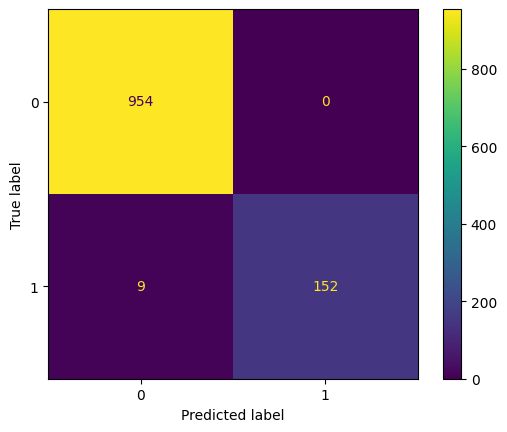

In [17]:
cm = confusion_matrix(y_test, pred_binary)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [18]:
f1_score(y_test, pred_binary)

0.9712460063897763

CONCLUSION:

Confusion Matrix:
* True Positives(152) - The number of spams correctly predicted as spams, we want to maximize this
* True Negatives(954) - The number of hams correctly predicted as hams, we want to maximize this
* False Positives(0)  - The number of hams mispredicted as spams, we want to minimize this
* False Negatives(9) - The number of spams mispredicted as hams, we want to minimize this

F1_SCORE(0.971) - Ideally 1

In terms of its classification ability, this is an overall better model than the optimized random forest classifier because of the f1_score. It has also perfectly learned to classify hams which is a game changer for people who don't like their messages blocked. All this, while ALSO improving its recall. 

Saving model artifacts to be used by the inference code.

In [19]:
joblib.dump(tokenizer, c.TOKENIZER_JOBLIB)
joblib.dump(label_encoder, c.KERAS_LABEL_ENCODER_JOBLIB)
model.save(c.KERAS_CLASSIFIER)